<a href="https://colab.research.google.com/github/danielabebe1/ds_portfolio/blob/main/Chocolate%20Bar%20Rating%20Analysis/ChocolateBarRating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chocolate Bar Rating Analysis with Python


# 1)Inroduction:

According to Manhattan Chocolate Society, nine out of ten people LOVE chocolate and about a billion people eating it every day. Each year, residents of the United States collectively eat more than 2.8 billion pounds. However, not all chocolate bars are created equal! This dataset contains expert ratings of over 2200 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown. The dataset used in this project was acquired from kaggle, it is compiled by Brady Brelinski, Founding Member of the Manhattan Chocolate Society. [Dataset](https://www.kaggle.com/soroushghaderi/chocolate-bar-2020)

Each chocolate is evaluated from a combination of both objective qualities and subjective interpretation. A rating here only represents an experience with one bar from one batch. Batch numbers, vintages and review dates are included in the database when known.

The database is narrowly focused on plain dark chocolate to appreciate the flavors of the cacao when made into chocolate. *The ratings do not reflect health benefits, social missions, or organic status.*
## ***Problem Statement:*** 
 ### *What qualities make for a highly rated chocolate bar?*


In [ ]:
!pip install --upgrade --quiet shap lime
!python -m pip install git+https://github.com/pwaller/pyfiglet

  Cloning https://github.com/pwaller/pyfiglet to /tmp/pip-req-build-bdk23vo0
  Running command git clone -q https://github.com/pwaller/pyfiglet /tmp/pip-req-build-bdk23vo0
  Created wheel for pyfiglet: filename=pyfiglet-0.8.post1-py2.py3-none-any.whl size=866300 sha256=af2208f8c987ca731addcff84587311a3466544411e5a656a9728bcb9757a66f
  Stored in directory: /tmp/pip-ephem-wheel-cache-7nd7oi7h/wheels/66/c0/fa/378b1362f029880a3a931840608e21efe7573a2f896e9b0cd7
Successfully built pyfiglet


# 2) Understading the Dataset
 ## 2.1) Import Libraries

In [ ]:
#DATA WRANGLING
import pandas as pd
import numpy as np
import math
import os
from scipy.stats import ttest_ind,randint
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

#MODELING
from sklearn.model_selection import train_test_split, StratifiedKFold,RandomizedSearchCV
import lightgbm as lgb
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
#VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

#INTERPRETATION
from sklearn import metrics
import shap
import lime
import lime.lime_tabular
from lime.lime_text import LimeTextExplainer

import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS

#FUN
import pyfiglet 
from termcolor import colored
from pyfiglet import figlet_format


##2.2 Load Dataset

After loading the dataset, we can also gain an understanding of our data by taking a peek into first few records.

In [ ]:
#load dataset using pandas read_csv attribute and form DataFrame
df = pd.read_csv('/content/drive/MyDrive/chocolate.csv')

Let's start the data wrangling by looking at the data frame shape and info. The dataset has 2224 instances or records and 21 featues. The dataset info looks perfect as it matches with the preview above. There are only six numerical featues and all the remaining features are categorical (object) columns. There are also columns that have null values such as second_taste, third_taste and fourth_taste.

In [ ]:
print('Number of Instances are:', df.shape[0], 'and Number of features are:', df.shape[1])
df.info()

Number of Instances are: 2224 and Number of features are: 21
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        2224 non-null   int64  
 1   ref                               2224 non-null   int64  
 2   company                           2224 non-null   object 
 3   company_location                  2224 non-null   object 
 4   review_date                       2224 non-null   int64  
 5   country_of_bean_origin            2224 non-null   object 
 6   specific_bean_origin_or_bar_name  2224 non-null   object 
 7   cocoa_percent                     2224 non-null   float64
 8   rating                            2224 non-null   float64
 9   counts_of_ingredients             2224 non-null   int64  
 10  beans                             2224 non-null   object 
 11  cocoa_bu

##2.3 Data Wrangling

Some of the features are useless, for instance 'Unnamed: 0' is similar to the index or row number. All chocolate has beans hence the feature 'beans' has no effect on the dataset model. The other important decision we have to make here is, since we have the feature "country_of_bean_origin", we will get rid of "specific_bean_origin_or_bar_name".  The other useless feature is the 'ref' reference number. 

In [ ]:
# head() function allows us to see the top N amount of records (in this case 5 records) of data frame
df.head()

,Unnamed: 0,ref,company,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,rating,counts_of_ingredients,beans,cocoa_butter,vanilla,lecithin,salt,sugar,sweetener_without_sugar,first_taste,second_taste,third_taste,fourth_taste
0,0,2454,5150,U.S.A,2019,Madagascar,"Bejofo Estate, batch 1",76.0,3.75,3,have_bean,have_cocoa_butter,have_not_vanila,have_not_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,cocoa,blackberry,full body,NaN
1,1,2458,5150,U.S.A,2019,Dominican republic,"Zorzal, batch 1",76.0,3.50,3,have_bean,have_cocoa_butter,have_not_vanila,have_not_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,cocoa,vegetal,savory,NaN
2,2,2454,5150,U.S.A,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,3.25,3,have_bean,have_cocoa_butter,have_not_vanila,have_not_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,rich cocoa,fatty,bready,NaN
3,3,797,A. Morin,France,2012,Peru,Peru,63.0,3.75,4,have_bean,have_cocoa_butter,have_not_vanila,have_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,fruity,melon,roasty,NaN
4,4,797,A. Morin,France,2012,Bolivia,Bolivia,70.0,3.50,4,have_bean,have_cocoa_butter,have_not_vanila,have_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,vegetal,nutty,NaN,NaN


In [ ]:
df.beans.value_counts()

have_bean    2224
Name: beans, dtype: int64

In [ ]:
#drop unneccessary features
df = df.drop(['Unnamed: 0','ref', 'specific_bean_origin_or_bar_name','beans'], axis = 1) 

Now let's check if there is a missing values using isnull() function and sum the result to know the cumulative missed values using sum() function. Looking at the result, second taste, third taste and fourth taste has a missing value of 77, 620 and 1982 respectively. From general knowledge and with a simple research one can find out that CHOCOLATE may have a single taste. So the missed values might not really missed but the chocolate has no other taste combinations. Therefore, it needs a bit of special attention. 
It is known that the taste of chocolate bar is very critical 

In [ ]:
df.isnull().sum()

company                       0
company_location              0
review_date                   0
country_of_bean_origin        0
cocoa_percent                 0
rating                        0
counts_of_ingredients         0
cocoa_butter                  0
vanilla                       0
lecithin                      0
salt                          0
sugar                         0
sweetener_without_sugar       0
first_taste                   0
second_taste                 77
third_taste                 620
fourth_taste               1982
dtype: int64

In the dataset, the count each tatsets ahs been given with 840 unique types of tastes. We can also find easly the type along with the frequency of each tastes.

In [ ]:
#create a list of all tastes in the first, second, third and fourth tastes.
tastes=[]
for col in df.first_taste:
  tastes.append(col)

for col in df.second_taste:
  tastes.append(col)

for col in df.third_taste:
  tastes.append(col)

for col in df.fourth_taste:
  tastes.append(col)

In [ ]:
#list the tastes along with there frequencies using counter function in the collection library
# and sort out with most common to least common
from collections import Counter
count = Counter(tastes)
count.most_common()

[(nan, 2679),
 ('nutty', 238),
 ('sweet', 237),
 ('cocoa', 203),
 ('roasty', 198),
 ('creamy', 184),
 ('earthy', 164),
 ('sandy', 153),
 ('fatty', 149),
 ('floral', 133),
 ('intense', 132),
 ('spicy', 122),
 ('sour', 122),
 ('molasses', 82),
 ('woody', 80),
 ('vanilla', 78),
 ('sticky', 77),
 ('fruit', 74),
 ('coffee', 69),
 ('rich', 67),
 ('gritty', 65),
 ('dried fruit', 60),
 ('dry', 59),
 ('bitter', 56),
 ('grassy', 56),
 ('tart', 54),
 ('caramel', 54),
 ('spice', 53),
 ('rich cocoa', 52),
 ('fruity', 47),
 ('complex', 47),
 ('oily', 46),
 ('smokey', 45),
 ('dairy', 42),
 ('banana', 41),
 ('brownie', 41),
 ('smoke', 39),
 ('acidic', 36),
 ('vegetal', 34),
 ('astringent', 32),
 ('tobacco', 31),
 ('off', 31),
 ('pungent', 31),
 ('cherry', 30),
 ('metallic', 30),
 ('hammy', 29),
 ('mild fruit', 28),
 ('nut', 28),
 ('mild bitter', 28),
 ('red berry', 27),
 ('coarse', 25),
 ('off notes', 25),
 ('strawberry', 24),
 ('black pepper', 24),
 ('honey', 24),
 ('citrus', 23),
 ('melon', 23),
 ('

Let's choose the first 20 most common tastes from 840 different tastes, we'll deal with it later and create a new feature that includes the list of tastes of chocolate bar composed of. 

In [ ]:
taste= ['cocoa','rich','fatty','roasty','nutty', 'sweet', 'sandy','sour','intense','mild','fruit','sticky','earthy','spice','molasses','floral',
        'spicy','woody','coffee','berry','vanilla', 'creamy']  
                  

In [ ]:
cols = ['first_taste',	'second_taste',	'third_taste',	'fourth_taste']
df['tastes'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df.head(2)

,company,company_location,review_date,country_of_bean_origin,cocoa_percent,rating,counts_of_ingredients,cocoa_butter,vanilla,lecithin,salt,sugar,sweetener_without_sugar,first_taste,second_taste,third_taste,fourth_taste,tastes
0,5150,U.S.A,2019,Madagascar,76.0,3.75,3,have_cocoa_butter,have_not_vanila,have_not_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,cocoa,blackberry,full body,NaN,cocoa blackberry full body nan
1,5150,U.S.A,2019,Dominican republic,76.0,3.50,3,have_cocoa_butter,have_not_vanila,have_not_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,cocoa,vegetal,savory,NaN,cocoa vegetal savory nan


In [ ]:
#the created feature inclues the NAN values, we'll get rid of that
df['tastes'] = df['tastes'].str.replace(r'nan', '')
df.head(2)

,company,company_location,review_date,country_of_bean_origin,cocoa_percent,rating,counts_of_ingredients,cocoa_butter,vanilla,lecithin,salt,sugar,sweetener_without_sugar,first_taste,second_taste,third_taste,fourth_taste,tastes
0,5150,U.S.A,2019,Madagascar,76.0,3.75,3,have_cocoa_butter,have_not_vanila,have_not_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,cocoa,blackberry,full body,NaN,cocoa blackberry full body
1,5150,U.S.A,2019,Dominican republic,76.0,3.50,3,have_cocoa_butter,have_not_vanila,have_not_lecithin,have_not_salt,have_sugar,have_not_sweetener_without_sugar,cocoa,vegetal,savory,NaN,cocoa vegetal savory


#2.4) Exploratory Data Analysis

The next important step after data wrangling is EXPLORATORY DATA ANALYSIS: where we can figure out the trends and the relationship between features, the effect of one feature over another, and identify the most influential variable. Generally, this step is where we Gain maximum insight into the data set and its underlying structure. At the point the data is seems clean but not really ready for machine learining model. Still we can dig deep and explore some insights from the wranglled but unprepared data. 

<Figure size 2160x1080 with 0 Axes>

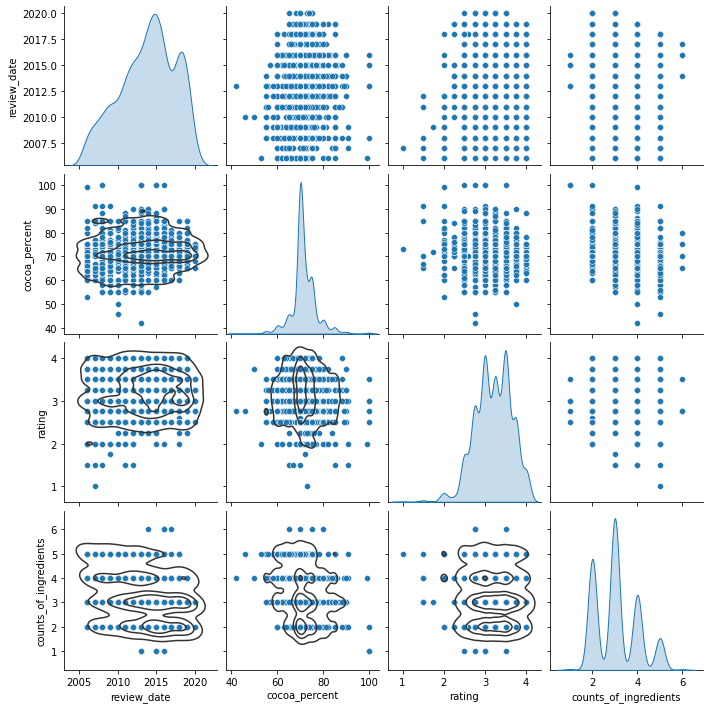

In [ ]:
plt.figure(figsize=(30, 15))
ax=sns.pairplot(df, diag_kind="kde")
ax.map_lower(sns.kdeplot, levels=4, color=".2")

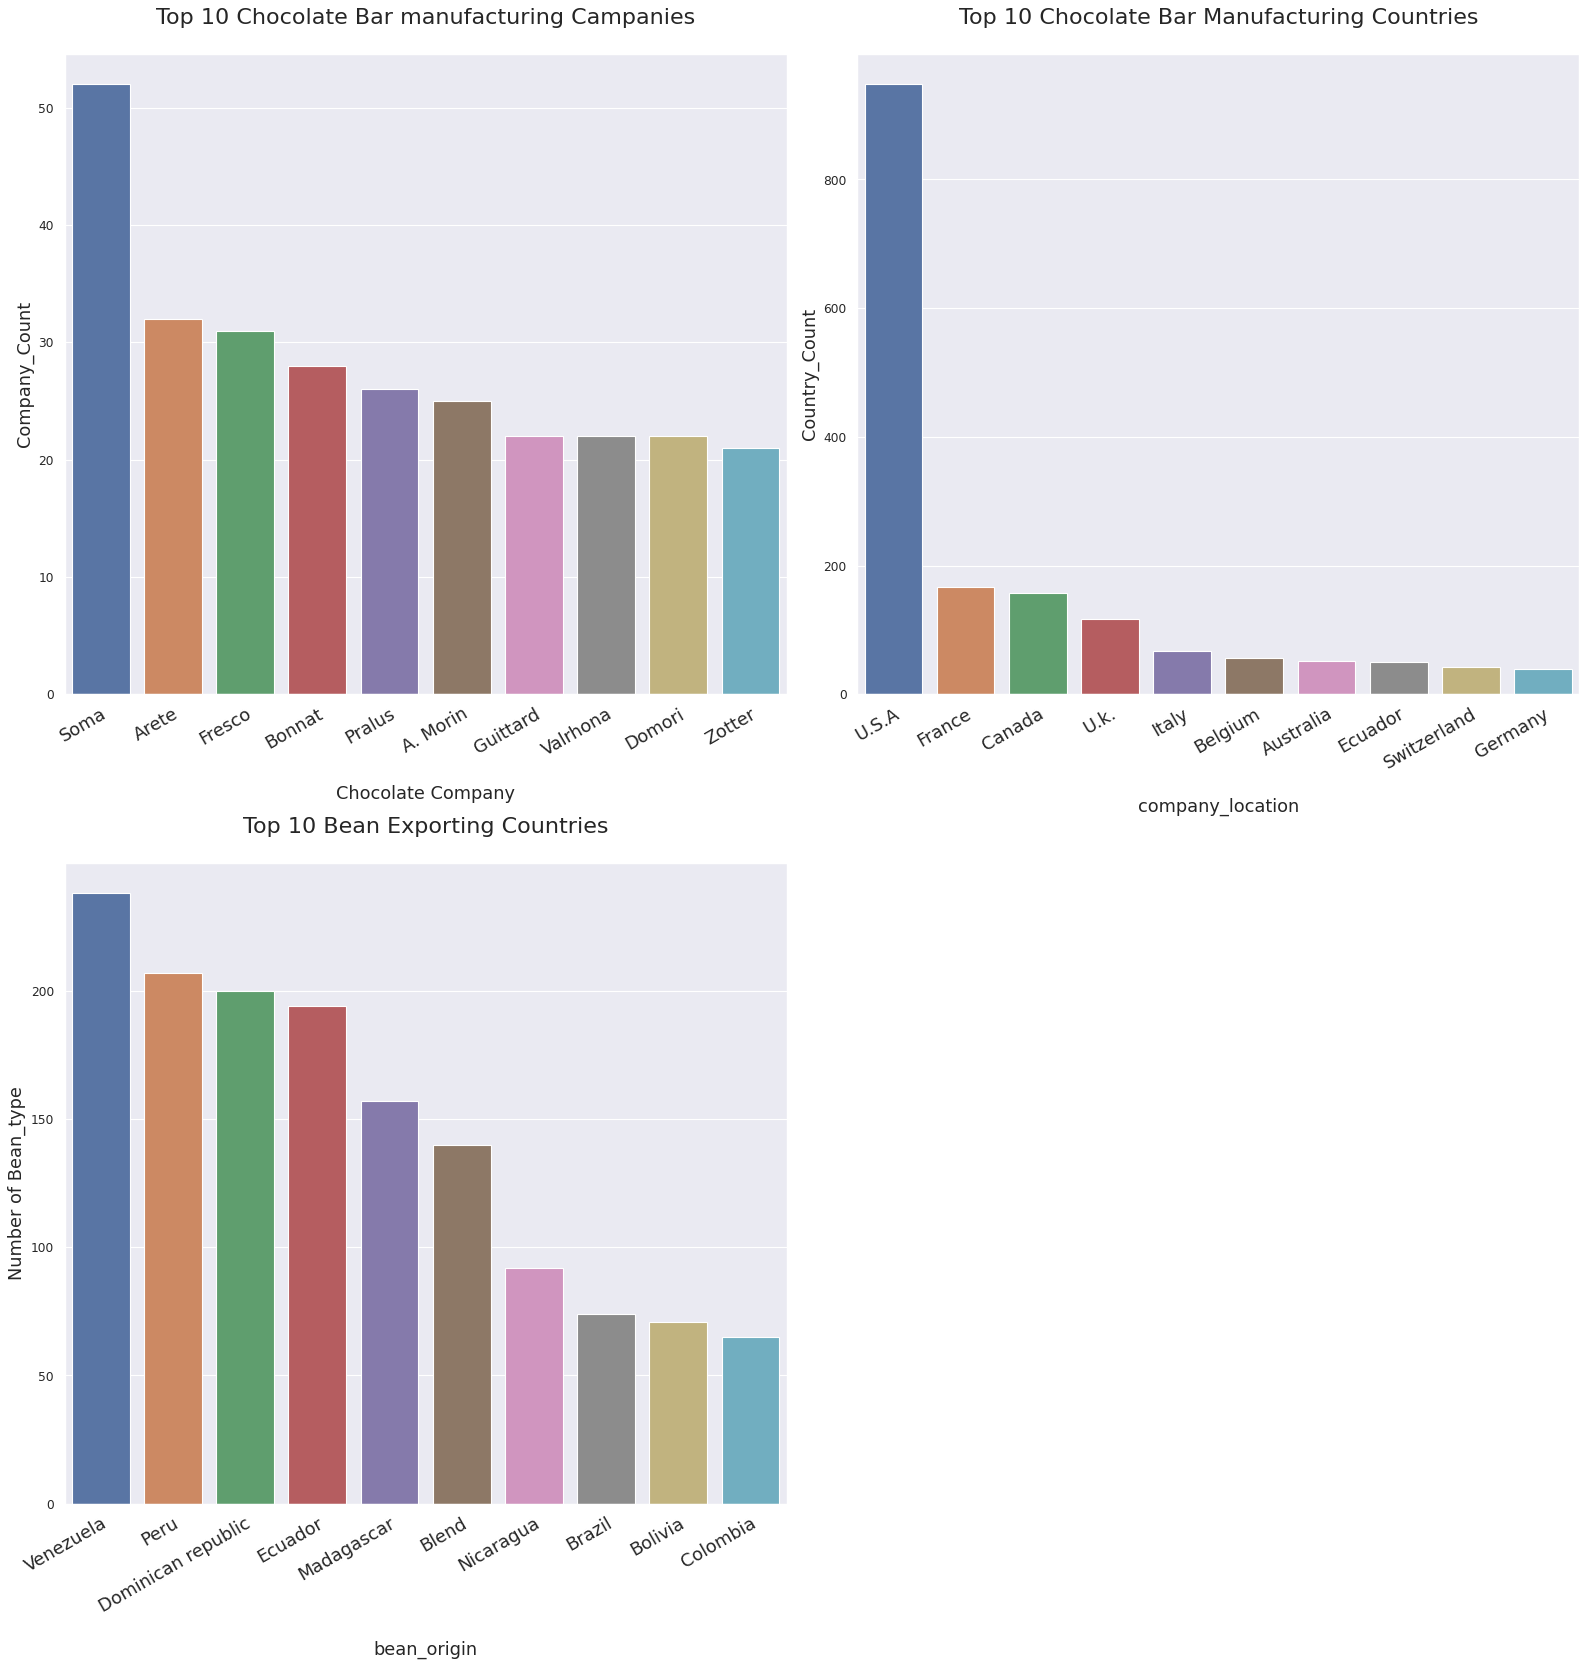

In [ ]:
# fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=False)

### Top 10 companies in terms of chocolate bars in this dataset
gp1 = df['company'].value_counts().sort_values(ascending=False).head(10)
gp1 = pd.DataFrame(gp1)
gp1 = gp1.reset_index() # dataframe with top 5 companies

### Top 10 countries that manufacture chocolate bars in this dataset
gp2 = df['company_location'].value_counts().sort_values(ascending=False).head(10)
gp2 = pd.DataFrame(gp2)
gp2 = gp2.reset_index() # dataframe with top 10 Bar manufacturing Countries

### Top 10 bean exporting countries
gp3 = df['country_of_bean_origin'].value_counts().sort_values(ascending=False).head(10)
gp3 = pd.DataFrame(gp3)
gp3 = gp3.reset_index() # dataframe with top 10 bean exporting countries


# Plotting
sns.set()
plt.figure(figsize=(20,21), dpi= 80)
plt.subplot(2,2,1)
ax=sns.barplot(x='index', y='company', data=gp1)
ax=plt.xticks(rotation=30, ha="right", rotation_mode="anchor", fontsize=16)
ax=plt.xlabel("\nChocolate Company", fontsize=16)
ax=plt.ylabel("Company_Count", fontsize=16)
ax=plt.title("Top 10 Chocolate Bar manufacturing Campanies\n", fontsize=20)

plt.subplot(2,2,2)
sns.barplot(x='index', y='company_location', data=gp2)
plt.xticks(rotation=30, ha="right", rotation_mode="anchor", fontsize=16)
plt.xlabel("\ncompany_location", fontsize=16)
plt.ylabel("Country_Count", fontsize=16)
plt.title("Top 10 Chocolate Bar Manufacturing Countries\n", fontsize=20)


plt.subplot(2,2,3)
sns.barplot(x='index', y='country_of_bean_origin', data=gp3)
plt.xticks(rotation=30, ha="right", rotation_mode="anchor", fontsize=16)
plt.xlabel("\nbean_origin", fontsize=16)
plt.ylabel("Number of Bean_type", fontsize=16)
plt.title("Top 10 Bean Exporting Countries\n", fontsize=20)
plt.tight_layout()



### The Effect of Bean origin and manufactring company on the chocolate bar rating

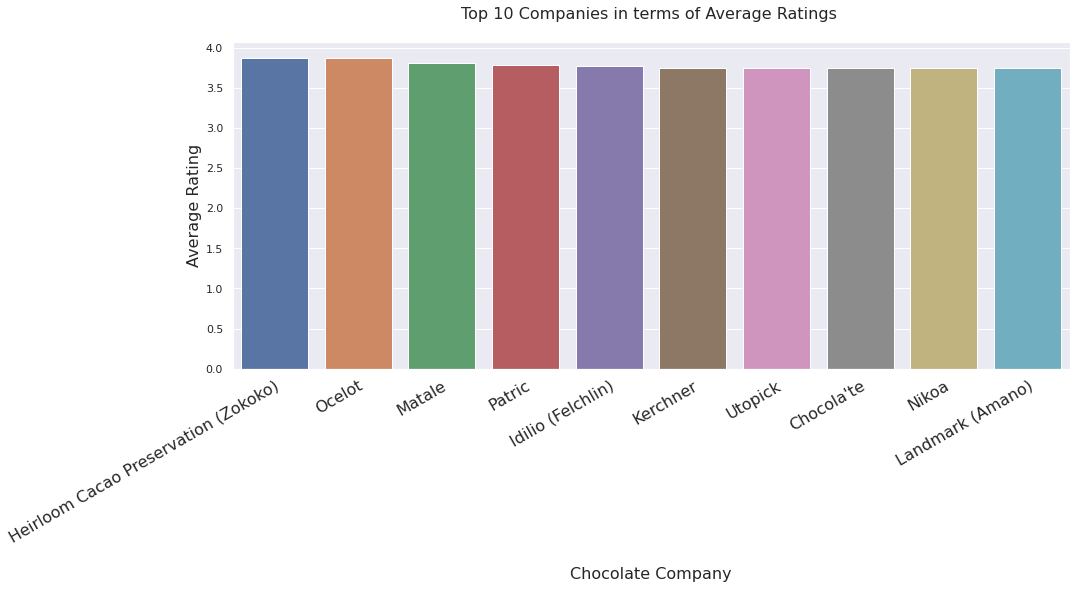

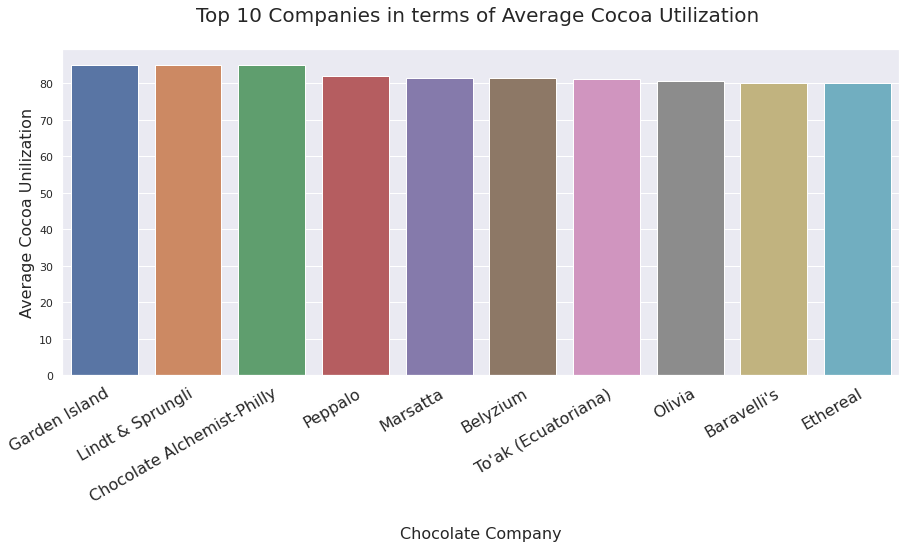

In [ ]:

# Top 10 companies in terms of average ratings
r1 = df.groupby('company').aggregate({'rating':'mean'})
r1 = r1.sort_values('rating', ascending=False).head(10)
r1 = r1.reset_index()
# Top 10 companies in terms of average Cocoa Percentage
p1 = df.groupby('company').aggregate({'cocoa_percent':'mean'})
p1 = p1.sort_values('cocoa_percent', ascending=False).head(10)
p1 = p1.reset_index()

# Plotting
sns.set()
plt.figure(figsize=(15, 6))
sns.barplot(x='company', y='rating', data=r1)
plt.xticks(rotation=30, ha="right", rotation_mode="anchor", fontsize=16)
plt.xlabel("\nChocolate Company", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.title("Top 10 Companies in terms of Average Ratings \n", fontsize=16)


plt.figure(figsize=(15, 6))
sns.barplot(x='company', y='cocoa_percent', data=p1)
plt.xticks(rotation=30, ha="right", rotation_mode="anchor", fontsize=16)
plt.xlabel("\nChocolate Company", fontsize=16)
plt.ylabel("Average Cocoa Unilization", fontsize=16)
plt.title("Top 10 Companies in terms of Average Cocoa Utilization \n", fontsize=20)
plt.show()




###Rating over time for top five companies

In [ ]:
ind=[]
for inds in gp1['index']:
  ind.append(inds)

ind=['Soma', 'Arete', 'Fresco', 'Bonnat', 'Pralus']


In [ ]:
ind

['Soma', 'Arete', 'Fresco', 'Bonnat', 'Pralus']

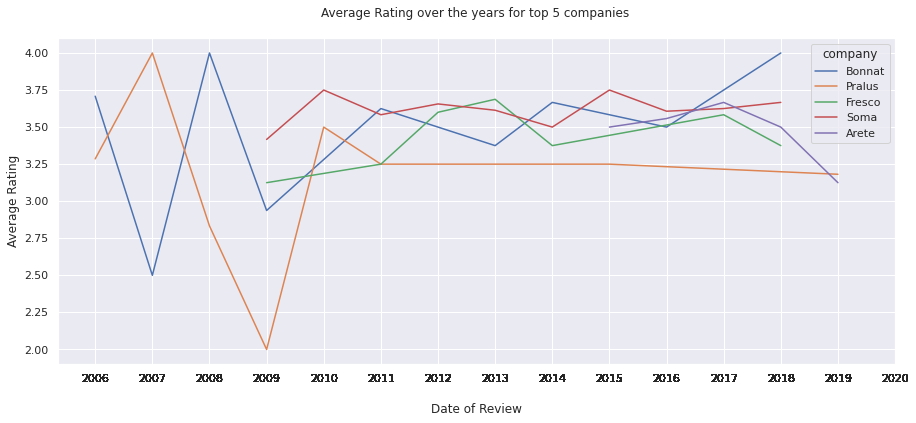

In [ ]:
### Rating patterns over the years

grp6 = df.groupby(['review_date', 'company']).aggregate({'rating':'mean'})
grp6 = grp6.reset_index()
grp6=grp6[grp6['company'].isin(ind)]


# Plotting
sns.set()
plt.figure(figsize=(15, 6))

ax = sns.lineplot(x='review_date', y='rating', hue='company', data=grp6)
ax.set(xticks=df.review_date.values)
plt.xlabel("\nDate of Review")
plt.ylabel("Average Rating")
plt.title("Average Rating over the years for top 5 companies \n")
plt.show()

###The Effect of Time - How did the Chocolate world change along the years?

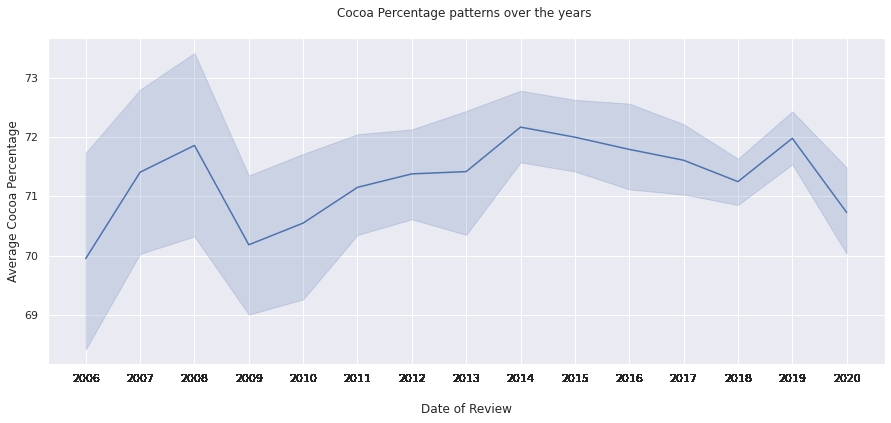

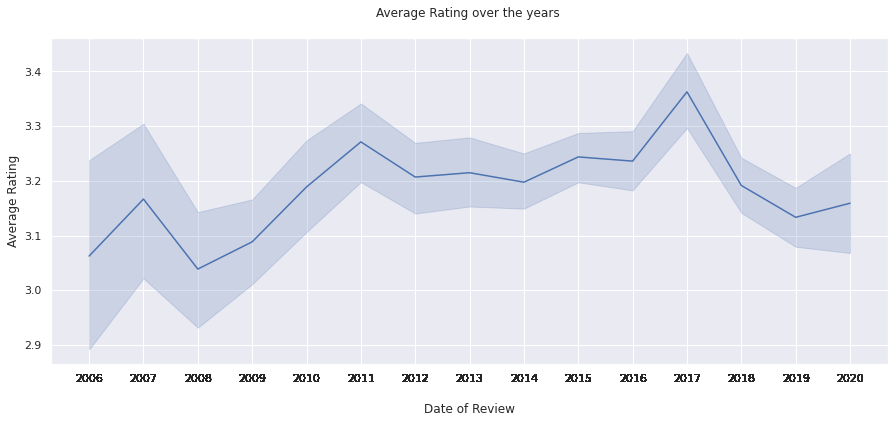

In [ ]:
### Cocoa Percentage patterns over the years

grp1 = df.groupby('review_date').aggregate({'cocoa_percent':'mean'})
grp1 = grp1.reset_index()

# Plotting
sns.set()
plt.figure(figsize=(15, 6))
ax = sns.lineplot(x='review_date', y='cocoa_percent', data=df)
ax.set(xticks=df.review_date.values)
plt.xlabel("\nDate of Review")
plt.ylabel("Average Cocoa Percentage")
plt.title("Cocoa Percentage patterns over the years \n")


### Rating patterns over the years

grp2 = df.groupby('review_date').aggregate({'rating':'mean'})
grp2 = grp2.reset_index()

# Plotting
sns.set()
plt.figure(figsize=(15, 6))
ax = sns.lineplot(x='review_date', y='rating', data=df)
ax.set(xticks=df.review_date.values)
plt.xlabel("\nDate of Review")
plt.ylabel("Average Rating")
plt.title("Average Rating over the years \n")
plt.show()

Percentage of Cocoa over the years (Taking the average amounts per year)
- The highest percentage of cocoa in a chocolate bar came in 2008 and was about 73%.
- The lowest percentage of cocoa followed in the very next year, 2009 and hit 69%.
- There was a rocky rise in the amount of cocoa in chocolate from 2009 to 2013 where it rose to about 72.2% from 69%.
- From 2014, a steady decline in cocoa percentage in chocolate bars have been noticed and in 2017, it stands at just above 71.5%.

###*Rating over the years (Taking the average amounts per year)*
- The lowest ever average rating was around 3 and it came in 2008.
- Since then to 2011, there was a steady increase in average ratings and in 2011 it was at 3.26.
- From 2011 to 2017, there have been several fluctuations in the ratings and in 2017, the rating lies at its apex at around 3.31.


###*The Year 2008 - Year of Coincidence or something more than that?*
- The highest average coca percent was in 2008.
- The lowest average ratings came in 2008.
The next year 2009 saw two major changes from the previous year :

- There was a drastic reduce in cocoa content on an average
- The average rating had a very steep increase to 3.08 from 3.00 in 2008


Is this an indication of how chocolate producers tried reducing their cocoa content to make better chocolate? OR was this just co-incidence?
Let's leave that to your speculation.

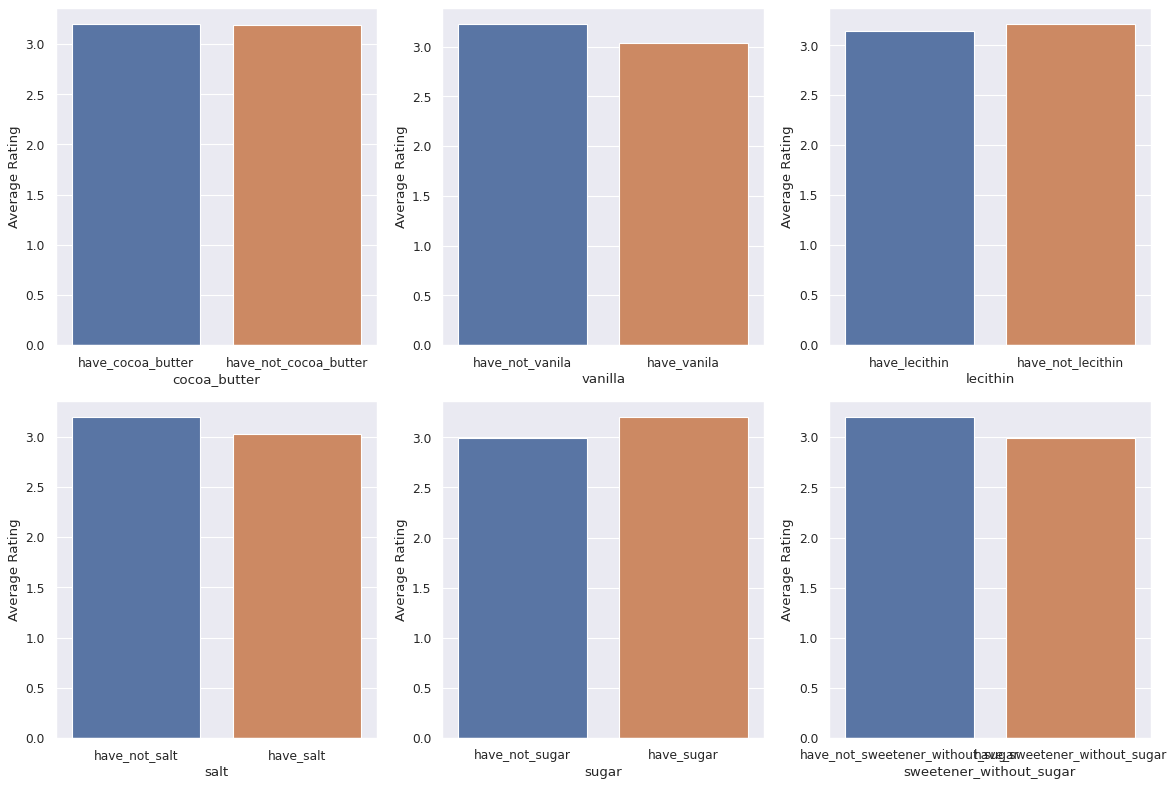

In [ ]:
### Rating patterns over the years

gp1 = df.groupby('cocoa_butter').aggregate({'rating':'mean'})
gp1 = gp1.reset_index()
gp2 = df.groupby('vanilla').aggregate({'rating':'mean'})
gp2 = gp2.reset_index()
gp3 = df.groupby('lecithin').aggregate({'rating':'mean'})
gp3 = gp3.reset_index()
gp4 = df.groupby('salt').aggregate({'rating':'mean'})
gp4 = gp4.reset_index()
gp5 = df.groupby('sugar').aggregate({'rating':'mean'})
gp5 = gp5.reset_index()
gp6 = df.groupby('sweetener_without_sugar').aggregate({'rating':'mean'})
gp6 = gp6.reset_index()


# Plotting
sns.set()
plt.figure(figsize=(15,10), dpi= 80)
plt.ylabel("Average Rating")
plt.subplot(2, 3, 1)
ax = sns.barplot(x='cocoa_butter', y='rating', data=gp1)
plt.ylabel("Average Rating")
plt.subplot(2, 3, 2)
ax = sns.barplot(x='vanilla', y='rating', data=gp2)
plt.ylabel("Average Rating")
plt.subplot(2, 3, 3)
ax = sns.barplot(x='lecithin', y='rating', data=gp3)
plt.ylabel("Average Rating")
plt.subplot(2, 3, 4)
ax = sns.barplot(x='salt', y='rating', data=gp4)
plt.ylabel("Average Rating")
plt.subplot(2, 3, 5)
ax = sns.barplot(x='sugar', y='rating', data=gp5)
plt.ylabel("Average Rating")
plt.subplot(2, 3, 6)
ax = sns.barplot(x='sweetener_without_sugar', y='rating', data=gp6)
plt.ylabel("Average Rating")
plt.tight_layout()
plt.show()

In [ ]:
#since the maximum rating is 4 which is under outstading, so let's see which company and bean_orgin falls under this rating
max_rating=df[df['rating']==4]

In [ ]:
print("Companies with high rated chocolate bars are: ", max_rating.company.value_counts().head(2))
print("Cantries that manufacture high rated chocolate bars are: ", max_rating.company_location.value_counts().head(2))
print("Bean Origin used to manufacture high rated chocolate bars are: ", max_rating.country_of_bean_origin.value_counts().head(2))
print("The taste of high rated chocolate bars : ", max_rating.tastes.value_counts().head(2))
print("The cocoa_percent of high rated chocolate bars : ", max_rating.cocoa_percent.value_counts().head(2))

Companies with high rated chocolate bars are:  Soma      13
Bonnat     8
Name: company, dtype: int64
Cantries that manufacture high rated chocolate bars are:  U.S.A     36
France    16
Name: company_location, dtype: int64
Bean Origin used to manufacture high rated chocolate bars are:  Venezuela    18
Peru         16
Name: country_of_bean_origin, dtype: int64
The taste of high rated chocolate bars :  cardamon              1
nutty tart coffee     1
Name: tastes, dtype: int64
The cocoa_percent of high rated chocolate bars :  70.0    52
75.0    15
Name: cocoa_percent, dtype: int64


From the graghical correlation plot, we can note that review_date and rating have positively correlation. cocoa_percent and number of ingredients have negative correlation with rating. 

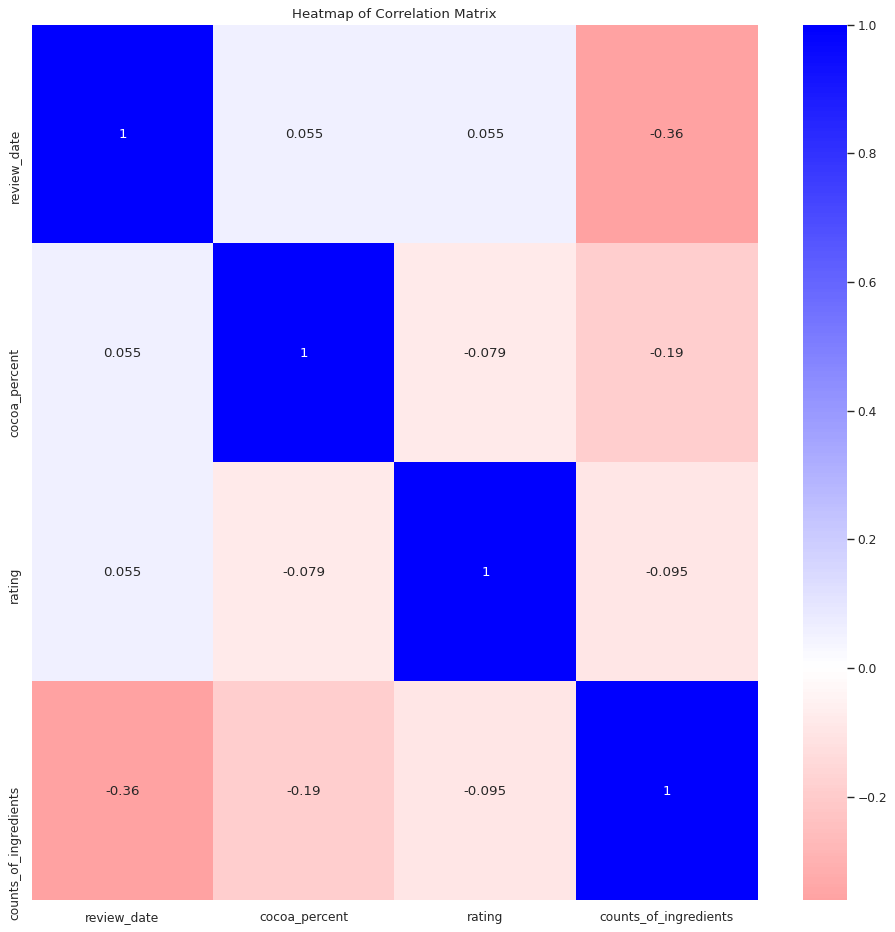

In [ ]:
#graphical representation of corellation
plt.figure(figsize=(12,12), dpi= 80)
hm=sns.heatmap(df.corr(), annot=True,center = 0,cmap='bwr_r', cbar=True)
plt.title('Heatmap of Correlation Matrix')
plt.tight_layout()

###Take away from the EDA

- The cocoa percentage of high rated chocolate bar is between 69%-72% and the best is for cocoa percentage of 71.5%.
- Bean from Venezuela and Peru are the best source of beans used to make chocolate bar.
- A three types of ingredients are preferable then two ingredients
- The rating companies generally improved through time.
- Soma is the best chocolate bar manufacturing company and it is based in USA
 

#3) Data Preparation

Data pre-processing techniques generally refer to the addition, deletion, or transformation of training set data. Data preparation involves best exposing the unknown underlying structure of the data to learning algorithms. 

In [ ]:
# create dictionary of ordinal to integer mapping
enc_categorical= {'cocoa_butter': {'have_cocoa_butter': 1,'have_not_cocoa_butter':0 }, 
              'vanilla':{'have_vanila': 1,'have_not_vanila':0 },
              'lecithin':{'have_lecithin': 1,'have_not_lecithin':0 },
              'salt':{'have_salt': 1,'have_not_salt':0 },
              'sugar':{'have_sugar': 1,'have_not_sugar':0 }, 
              'sweetener_without_sugar':{'have_sweetener_without_sugar': 1,'have_not_sweetener_without_sugar':0 }}


In [ ]:
#apply the created dictionary using repalce function 
df=df.replace(enc_categorical)
df.head(2)

,company,company_location,review_date,country_of_bean_origin,cocoa_percent,rating,counts_of_ingredients,cocoa_butter,vanilla,lecithin,salt,sugar,sweetener_without_sugar,first_taste,second_taste,third_taste,fourth_taste,tastes
0,5150,U.S.A,2019,Madagascar,76.0,3.75,3,1,0,0,0,1,0,cocoa,blackberry,full body,NaN,cocoa blackberry full body
1,5150,U.S.A,2019,Dominican republic,76.0,3.50,3,1,0,0,0,1,0,cocoa,vegetal,savory,NaN,cocoa vegetal savory


In [ ]:
top_country_of_bean_origin=['Venezuela','Blend','Dominican republic','Ecuador','Madagascar','Nicaragua','Peru']
Others=[]
for col in df.country_of_bean_origin:
  if col not in top_country_of_bean_origin:
    Others.append(col)

dict1={}
for i in Others:
  dict1[i] = "Other"

df=df.replace(dict1)
df.head(2)

,company,company_location,review_date,country_of_bean_origin,cocoa_percent,rating,counts_of_ingredients,cocoa_butter,vanilla,lecithin,salt,sugar,sweetener_without_sugar,first_taste,second_taste,third_taste,fourth_taste,tastes
0,5150,U.S.A,2019,Madagascar,76.0,3.75,3,1,0,0,0,1,0,cocoa,blackberry,full body,NaN,cocoa blackberry full body
1,5150,U.S.A,2019,Dominican republic,76.0,3.50,3,1,0,0,0,1,0,cocoa,vegetal,savory,NaN,cocoa vegetal savory


In [ ]:
df.replace({'Dominican republic': 'Dominican_republic'}, inplace=True)
top_company_location=['U.S.A','France','Canada','U.k.','Italy','Belgium','Australia','Ecuador']
Others1=[]
for col in df.company_location:
  if col not in top_company_location:
    Others1.append(col)

dict2={}
for i in Others1:
  dict2[i] = "Other"

df1=df.company_location.replace(dict2)

In [ ]:
#concatenate data frames
df2=pd.concat([df1, df.reindex(df1.index)], axis=1)
#drop dupilicated columns
df = df2.loc[:,~df2.columns.duplicated()]

In [ ]:
#using pd.get_dummies to create a one hot encoded matrix
dummies = pd.get_dummies(df['company_location'])
#Adding the variable to the column names so we can keep track of which original variable it came from
dummies.columns = ['company_location_' + k for k in dummies.columns.values]

df = pd.concat([df, dummies], axis=1)

#dropping the original column 
del df['company_location']


In [ ]:
#using pd.get_dummies to create a one hot encoded matrix
dummies = pd.get_dummies(df['country_of_bean_origin'])
#Adding the variable to the column names so we can keep track of which original variable it came from
dummies.columns = ['country_of_bean_origin_' + k for k in dummies.columns.values]

df = pd.concat([df, dummies], axis=1)

#dropping the original column 
del df['country_of_bean_origin']


In [ ]:
Others2=[]
for col in df.first_taste:
  if col not in taste:
    Others2.append(col)

dict3={}
for i in Others2:
  dict3[i] = "Other"

df2=df.first_taste.replace(dict3)

In [ ]:
Others3=[]
for col in df.second_taste:
  if col not in taste:
    Others3.append(col)

dict4={}
for i in Others3:
  dict4[i] = "Other"

df3=df.second_taste.replace(dict4)

In [ ]:
Others4=[]
for col in df.third_taste:
  if col not in taste:
    Others4.append(col)

dict5={}
for i in Others4:
  dict5[i] = "Other"

df4=df.third_taste.replace(dict5)

In [ ]:
Others5=[]
for col in df.fourth_taste:
  if col not in taste:
    Others5.append(col)

dict6={}
for i in Others5:
  dict6[i] = "Other"

df5=df.fourth_taste.replace(dict6)

In [ ]:
#concatenate the data frames
df6=pd.concat([df2,df3,df4,df5, df.reindex(df1.index)], axis=1)
#drop the dupilicated columns
df = df6.loc[:,~df6.columns.duplicated()]

In [ ]:
#using pd.get_dummies to create a one hot encoded matrix
dummies = pd.get_dummies(df['first_taste'])
#Adding the variable to the column names so we can keep track of which original variable it came from
dummies.columns = ['tastes_' + k for k in dummies.columns.values]

df1 = pd.concat([df, dummies], axis=1)

#dropping the original column 
del df1['first_taste']


In [ ]:
#using pd.get_dummies to create a one hot encoded matrix
dummies = pd.get_dummies(df1['second_taste'])
#Adding the variable to the column names so we can keep track of which original variable it came from
dummies.columns = ['tastes_' + k for k in dummies.columns.values]

df2 = pd.concat([df1, dummies], axis=1)

#dropping the original column 
del df2['second_taste']


In [ ]:
#using pd.get_dummies to create a one hot encoded matrix
dummies = pd.get_dummies(df2['third_taste'])
#Adding the variable to the column names so we can keep track of which original variable it came from
dummies.columns = ['tastes_' + k for k in dummies.columns.values]

df3 = pd.concat([df2, dummies], axis=1)

#dropping the original column 
del df3['third_taste']


In [ ]:
#using pd.get_dummies to create a one hot encoded matrix
dummies = pd.get_dummies(df3['fourth_taste'])
#Adding the variable to the column names so I can keep track of which original variable it came from
dummies.columns = ['tastes_' + k for k in dummies.columns.values]

df4 = pd.concat([df3, dummies], axis=1)

#dropping the original column 
del df4['fourth_taste']

df4.head(2)

,company,review_date,cocoa_percent,rating,counts_of_ingredients,cocoa_butter,vanilla,lecithin,salt,sugar,sweetener_without_sugar,tastes,company_location_Belgium,company_location_Canada,company_location_Ecuador,company_location_France,company_location_Italy,company_location_Other,company_location_U.S.A,company_location_U.k.,country_of_bean_origin_Blend,country_of_bean_origin_Dominican_republic,country_of_bean_origin_Ecuador,country_of_bean_origin_Madagascar,country_of_bean_origin_Nicaragua,country_of_bean_origin_Other,country_of_bean_origin_Peru,country_of_bean_origin_Venezuela,tastes_Other,tastes_berry,tastes_cocoa,tastes_coffee,tastes_creamy,tastes_earthy,tastes_fatty,tastes_floral,tastes_fruit,tastes_intense,tastes_mild,tastes_molasses,...,tastes_cocoa,tastes_coffee,tastes_creamy,tastes_earthy,tastes_fatty,tastes_floral,tastes_fruit,tastes_intense,tastes_mild,tastes_molasses,tastes_nutty,tastes_rich,tastes_roasty,tastes_sandy,tastes_sour,tastes_spice,tastes_spicy,tastes_sticky,tastes_sweet,tastes_vanilla,tastes_woody,tastes_Other,tastes_berry,tastes_cocoa,tastes_coffee,tastes_earthy,tastes_fatty,tastes_floral,tastes_fruit,tastes_intense,tastes_nutty,tastes_rich,tastes_roasty,tastes_sandy,tastes_sour,tastes_spice,tastes_spicy,tastes_sweet,tastes_vanilla,tastes_woody
0,5150,2019,76.0,3.75,3,1,0,0,0,1,0,cocoa blackberry full body,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5150,2019,76.0,3.50,3,1,0,0,0,1,0,cocoa vegetal savory,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#drop dupilicated columns
choco = df4.loc[:,~df4.columns.duplicated()]
#drop the psedo taste
choco = choco.drop('tastes_Other', axis = 1)

In [ ]:
choco.head(1)

,company,review_date,cocoa_percent,rating,counts_of_ingredients,cocoa_butter,vanilla,lecithin,salt,sugar,sweetener_without_sugar,tastes,company_location_Belgium,company_location_Canada,company_location_Ecuador,company_location_France,company_location_Italy,company_location_Other,company_location_U.S.A,company_location_U.k.,country_of_bean_origin_Blend,country_of_bean_origin_Dominican_republic,country_of_bean_origin_Ecuador,country_of_bean_origin_Madagascar,country_of_bean_origin_Nicaragua,country_of_bean_origin_Other,country_of_bean_origin_Peru,country_of_bean_origin_Venezuela,tastes_berry,tastes_cocoa,tastes_coffee,tastes_creamy,tastes_earthy,tastes_fatty,tastes_floral,tastes_fruit,tastes_intense,tastes_mild,tastes_molasses,tastes_nutty,tastes_rich,tastes_roasty,tastes_sandy,tastes_sour,tastes_spice,tastes_spicy,tastes_sticky,tastes_sweet,tastes_vanilla,tastes_woody
0,5150,2019,76.0,3.75,3,1,0,0,0,1,0,cocoa blackberry full body,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
'company'	'review_date'	'cocoa_percent'	'rating'	'counts_of_ingredients'	'cocoa_butter'	'vanilla'	'lecithin'	'salt'	'sugar'	'sweetener_without_sugar'	'tastes'	'company_location_Belgium'	'company_location_Canada'	'company_location_Ecuador'	'company_location_France'	'company_location_Italy'	'company_location_Other'	'company_location_U.S.A'	'company_location_U.k.'	country_of_bean_origin_Blend	country_of_bean_origin_Dominican_republic	country_of_bean_origin_Ecuador	country_of_bean_origin_Madagascar	country_of_bean_origin_Nicaragua	country_of_bean_origin_Other	country_of_bean_origin_Peru	country_of_bean_origin_Venezuela	tastes_berry	tastes_cocoa	tastes_coffee	tastes_creamy	tastes_earthy	tastes_fatty	tastes_floral	'tastes_fruit'	'tastes_intense'	'tastes_mild'	'tastes_molasses'	'tastes_nutty'	'tastes_rich'	'tastes_roasty'	'tastes_sandy'	'tastes_sour'	'tastes_spice'	'tastes_spicy'	'tastes_sticky'	'tastes_sweet'	'tastes_vanilla'	'tastes_woody'

In [ ]:
#rearrange columns 
cols= ['company', 'review_date', 'cocoa_percent', 'rating','counts_of_ingredients', 'cocoa_butter', 'vanilla', 'lecithin', 'salt',
       'sugar', 'sweetener_without_sugar', 'company_location_Canada', 'company_location_France', 'company_location_Other',
       'company_location_U.S.A', 'company_location_U.k.', 'country_of_bean_origin_Blend', 'country_of_bean_origin_Dominican_republic',
       'country_of_bean_origin_Ecuador', 'country_of_bean_origin_Madagascar','country_of_bean_origin_Nicaragua', 'country_of_bean_origin_Other',
       'country_of_bean_origin_Peru', 'country_of_bean_origin_Venezuela', 'tastes_cocoa','tastes_rich','tastes_fatty','tastes_roasty','tastes_nutty',
       'tastes_sweet','tastes_sandy','tastes_sour','tastes_intense','tastes_mild','tastes_fruit','tastes_sticky','tastes_earthy', 'tastes_spice',
       'tastes_molasses','tastes_floral','tastes_spicy','tastes_woody', 'tastes_coffee','tastes_berry','tastes_vanilla','tastes_creamy','tastes']

choco=choco[cols]

In [ ]:
 
# #let's pickle for later use
# choco.to_pickle("choco.pkl")

In [ ]:
# path='/content/drive/MyDrive/choco.pkl'
# infile = open(path,'rb')
# choco = pickle.load(infile)

In [ ]:
print(choco.shape)
choco.head(2)

(2224, 47)


,company,review_date,cocoa_percent,rating,counts_of_ingredients,cocoa_butter,vanilla,lecithin,salt,sugar,sweetener_without_sugar,company_location_Canada,company_location_France,company_location_Other,company_location_U.S.A,company_location_U.k.,country_of_bean_origin_Blend,country_of_bean_origin_Dominican_republic,country_of_bean_origin_Ecuador,country_of_bean_origin_Madagascar,country_of_bean_origin_Nicaragua,country_of_bean_origin_Other,country_of_bean_origin_Peru,country_of_bean_origin_Venezuela,tastes_cocoa,tastes_rich,tastes_fatty,tastes_roasty,tastes_nutty,tastes_sweet,tastes_sandy,tastes_sour,tastes_intense,tastes_mild,tastes_fruit,tastes_sticky,tastes_earthy,tastes_spice,tastes_molasses,tastes_floral,tastes_spicy,tastes_woody,tastes_coffee,tastes_berry,tastes_vanilla,tastes_creamy,tastes
0,5150,2019,76.0,3.75,3,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,cocoa blackberry full body
1,5150,2019,76.0,3.50,3,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,cocoa vegetal savory


#4) Modeling

##4.1) Train/Test Split

In [ ]:
# it's imperative to consistently use a seed number and set it to NumPy, 
# tensorflow or in whatever place a stochastic process exists and allows for it to be set.
rand = 9
np.random.seed(rand)
os.environ['EverythingHasSolution']=str(rand)

**The key of rating**

- 4.0 - 5.00 = Outstanding
- 3.5 - 3.90 = Highly Recommended
- 3.0 - 3.49 = Recommended
- 2.0 - 2.90 = Disappointing
- 1.0 - 1.90  = Unpleasant

In [ ]:
#We define `y` as `rating` column converted to 1's if greater than or equal to 3.5 and 0 otherwise
y = choco['rating'].apply(lambda x: 1 if x >= 3.5 else 0)

#`X` is everything else (excluding `company` and `tastes`)
X = choco.drop(['rating','company','tastes'], axis=1).copy()

#Create `X` and `y` and split them 67/33 corresponding for train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                test_size=0.33, random_state=rand)

##4.2) Define Evaluation Function

In [ ]:
def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, plot=True):
    """Given a classification model, plots an ROC curve and outputs some predictive
    performance metrics. Then it returns the predictions.
    
    Keyword arguments:
    fitted_model -- a fitted classification model with a `predict` or `predict_proba` function
    X_train -- training features (pandas dataframe or array)
    X_test -- test features (pandas dataframe or array)
    y_train -- training labels (pandas dataframe or array)
    y_test -- test labels (pandas dataframe or array)
    plot -- whether to display ROC plot or not (boolean)
    """
    
    sns.set()
    y_train_pred = fitted_model.predict(X_train).squeeze()
    if len(np.unique(y_train_pred)) > 2:
        y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
        y_test_prob = fitted_model.predict(X_test).squeeze()
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    else:   
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    roc_auc = metrics.roc_auc_score(y_test, y_test_prob)
    if plot:
        plt.figure(figsize = (9,8))
        plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_test_prob)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
        plt.xlabel('False Positive Rate', fontsize = 14)
        plt.ylabel('True Positive Rate', fontsize = 14)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.legend(loc="lower right")
        plt.show()
    print('\tAccuracy_train:  %.4f\t\tAccuracy_test:   %.4f' %\
                        (metrics.accuracy_score(y_train, y_train_pred),\
                         metrics.accuracy_score(y_test, y_test_pred)))
    print('\tPrecision_test:  %.4f\t\tRecall_test:     %.4f' %\
                        (metrics.precision_score(y_test, y_test_pred),\
                         metrics.recall_score(y_test, y_test_pred)))
    print('\tROC-AUC_test:    %.4f\t\tF1_test:         %.4f\t\tMCC_test: %.4f' %\
                        (roc_auc,\
                         metrics.f1_score(y_test, y_test_pred),\
                         metrics.matthews_corrcoef(y_test, y_test_pred)))
    return y_train_pred, y_test_prob, y_test_pred

##4.3) Train Support Vector Classification Model (on Tabular Dataset)

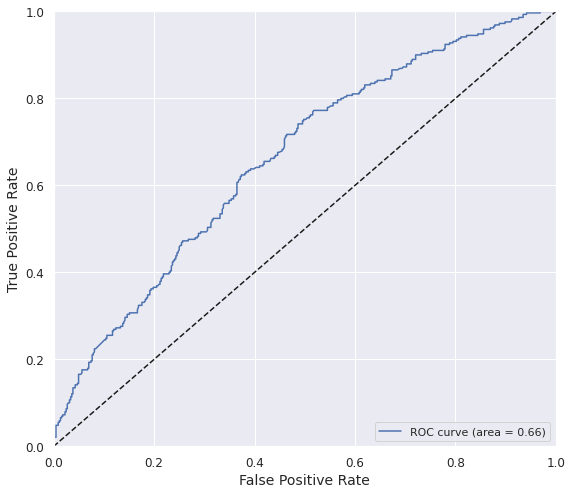

	Accuracy_train:  0.6530		Accuracy_test:   0.6431
	Precision_test:  0.6373		Recall_test:     0.2241
	ROC-AUC_test:    0.6616		F1_test:         0.3316		MCC_test: 0.1990


In [ ]:
#Initialize the model
svm_mdl = svm.SVC(probability=True, gamma='auto', random_state=rand)

#Fit the model
fitted_svm_mdl = svm_mdl.fit(X_train, y_train)

#Evaluate the model with our custom function
y_train_svc_pred, y_test_svc_prob, y_test_svc_pred =evaluate_class_mdl(fitted_svm_mdl, X_train, X_test, y_train, y_test)

## 4.3) Train Random Forest Classification Model (on Tabular Dataset)

In [ ]:
# Model: RandomForest [cross-validated and train set]
rf_cv = RandomForestClassifier(criterion='gini',n_estimators=50, max_depth=1, min_samples_split=2, random_state=rand, n_jobs=1)
rf_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options
param_dist_rf = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                  "min_samples_split": randint(2, 10),
                  "min_samples_leaf": randint(2, 10),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
random_search = RandomizedSearchCV(estimator=rf_cv, param_distributions=param_dist_rf, random_state=0, n_iter=100, cv=4)
random_search_rf = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best n_estimators:', random_search_rf.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_rf.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', random_search_rf.best_estimator_.get_params()['min_samples_split'])
print('Best bootstrap:', random_search_rf.best_estimator_.get_params()['bootstrap'])
print('Best min_samples_leaf:', random_search_rf.best_estimator_.get_params()['min_samples_leaf'])

Best n_estimators: 184
Best max_depth: 44
Best min_samples_split: 2
Best bootstrap: False
Best min_samples_leaf: 2


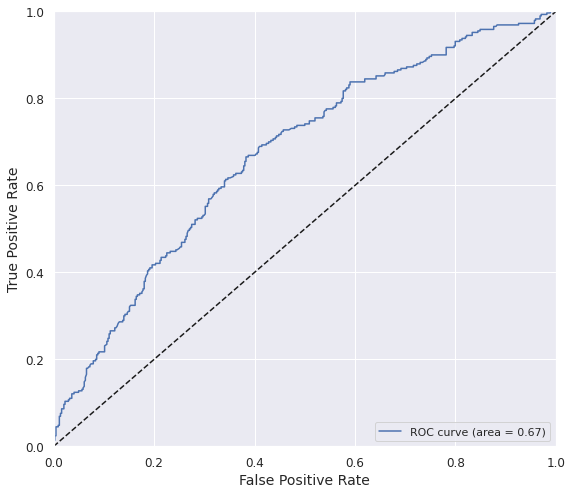

	Accuracy_train:  0.8732		Accuracy_test:   0.6403
	Precision_test:  0.5802		Recall_test:     0.3241
	ROC-AUC_test:    0.6709		F1_test:         0.4159		MCC_test: 0.2016


In [ ]:
#Initialize the model
rf_mdl = RandomForestClassifier(criterion='entropy', max_depth=44, min_samples_split=2, min_samples_leaf=2, n_estimators=184, 
                            bootstrap= False,random_state=rand)

#Fit the model
fitted_rf_mdl = rf_mdl.fit(X_train, y_train)

#Evaluate the model with our custom function
y_train_rf_pred, y_test_rf_prob, y_test_rf_pred =evaluate_class_mdl(fitted_rf_mdl, X_train, X_test, y_train, y_test)

### 4.4) Train/Test Split (NLP)

In addition to the tabular test and train datasets, for our NLP models, we will need text-only feature datasets that are consistent with our `train_test_split` so we can use the same `y` labels. 

In [ ]:
#We define the NLP version of the training data as the `tastes` column and 
# split according to the same train/test indexes
X_train_nlp = choco.loc[X_train.index, 'tastes']
X_test_nlp = choco.loc[X_test.index, 'tastes']

No machine learning model can ingest the data as text, so we need to turn it into a numerical format. In other words, vectorize it. There are many techniques to do this. In our case, we are not interested in the position of words in each phrase nor the semantics. However, we are interested in their relative occurrence. For these reasons, Term Frequency Inverse Document Frequency (TF-IDF) is the ideal method because it's meant to evaluate how often a term (each word) appears in the document (each phrase). However, it's weighted according to its frequency in the entire corpus (all phrases).

In [ ]:
#We can easily vectorize our datasets using the TF-IDF method with Sci-kit Learn's `TfidfVectorizer`
vectorizer = TfidfVectorizer(lowercase=False)

#Fit-transform according to the larger train data and simply transform with the test data
X_train_nlp_fit = vectorizer.fit_transform(X_train_nlp)
X_test_nlp_fit = vectorizer.transform(X_test_nlp)

To get an idea of what the TF-IDF score looks like, we can place all the feature names in one column of a data frame, and their respective scores for a single observation in another.

In [ ]:
#Note that, since the vectorizer produces a `scipy` sparse matrix, we have to convert it into numpy matrix
# with `todense()` and then a numpy array with `asarray()`. We can sort this data frame in descending order 
# by TD-IDF scores.
pd.DataFrame({'taste':vectorizer.get_feature_names(),\
              'tf-idf': np.asarray(X_test_nlp_fit[X_test_nlp.index==5].todense())[0]}).\
    sort_values(by='tf-idf', ascending=False)

,taste,tf-idf
318,raspberry,0.585538
268,nut,0.491542
276,oily,0.463973
71,caramel,0.447504
0,Andes,0.000000
...,...,...
142,empty,0.000000
141,edge,0.000000
140,easy,0.000000
139,earty,0.000000


##4.5) Train LightGBM Model (on NLP Dataset)

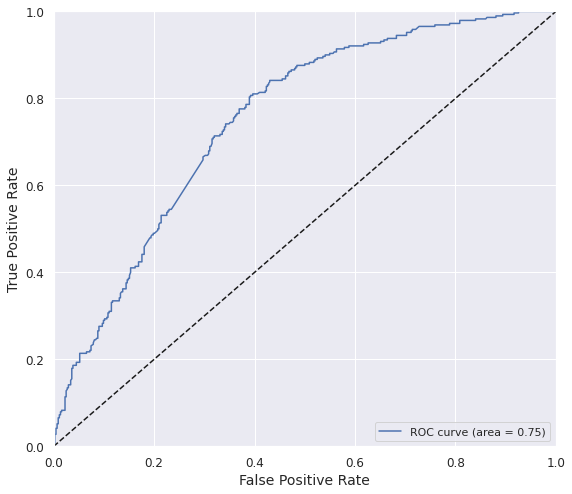

	Accuracy_train:  0.7987		Accuracy_test:   0.6771
	Precision_test:  0.6147		Recall_test:     0.4897
	ROC-AUC_test:    0.7506		F1_test:         0.5451		MCC_test: 0.3044


In [ ]:
#Initialize the model
lgb_mdl = lgb.LGBMClassifier(max_depth=13, learning_rate=0.05,\
                             n_estimators=100, objective='binary', random_state=rand)

#Fit the model
fitted_lgb_mdl = lgb_mdl.fit(X_train_nlp_fit, y_train)

#Evaluate the model with our custom function
y_train_lgb_pred, y_test_lgb_prob, y_test_lgb_pred =\
                                            evaluate_class_mdl(fitted_lgb_mdl, X_train_nlp_fit,\
                                                               X_test_nlp_fit, y_train, y_test)

#5) Interpretation of the Machine Learning MODEL
## 5.1) Global Intepretation with SHAP

First, initialize the explainer. 

In [ ]:
#KernelExplainer strongly suggests other measures to minimize computation. One of these is using `K-means` 
# to summarize the background training data instead of using it whole. Another method could be using a sample
# of the training data. In this case, we opted for k-means clustering into 10 centroids.
X_train_summary = shap.kmeans(X_train, 10)

#KernelExplainer takes a predict function for a model (`fitted_svm_mdl.predict_proba`) and
# some background training data (`X_train_summary`)
shap_svm_explainer = shap.KernelExplainer(fitted_svm_mdl.predict_proba,\
                                          X_train_summary)

Fit the explainer and display a summary.

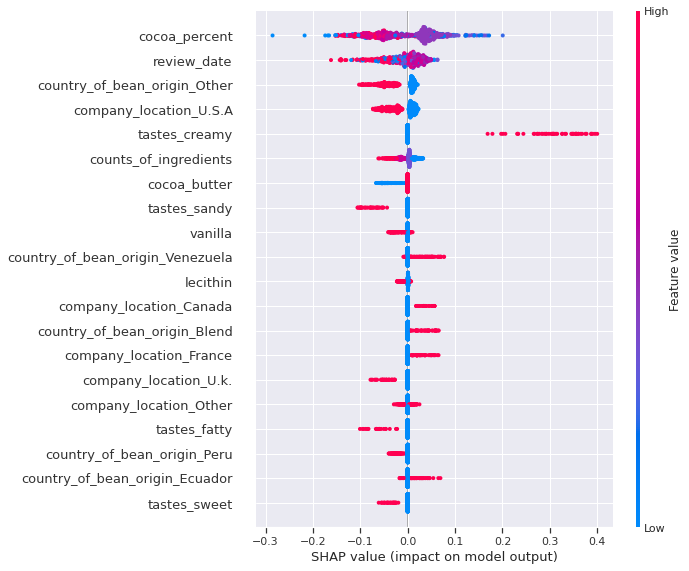

In [ ]:
#Once we have initialized our explainer, we can use samples of our test dataset (`nsamples=200`) to come up 
# with the Shapely Values. It uses L1 regularization (`l1_reg`) during the fitting process.  What we are telling 
# it here is to regularize to the point it only has 20 relevant features.
shap_svm_values_test = shap_svm_explainer.shap_values(X_test,\
                                nsamples=200, l1_reg="num_features(20)")

#We can use a `summary_plot` to plot our Shapely Values for class `1`
shap.summary_plot(shap_svm_values_test[1], X_test, plot_type="dot")

## 5.2) Local Intepretation
###5.2.1) Explore a Group of Points with SHAP Decision Plots

For local interpretation, you don't have to visualize one point at a time. We can interpret several at a time. The key is providing some context to compare the points adequately, and they can't be so many that you can't distinguish them. Usually, you would find outliers or only those that meet specific criteria. For this exercise, we will select only those bars that were produced by a specific French company:

In [ ]:
#Get indexes for a Group of Points
sample_test_idx = X_test.index.\
                    get_indexer_for([5,6,7,18,19,21,24,25,27])

#To highlight False Negatives from these points
FN = (y_test_svc_pred[sample_test_idx] == 0) &\
     (y_test.iloc[sample_test_idx] == 1).to_numpy() 

#Set the expected value for the positive class
expected_value = shap_svm_explainer.expected_value[1]

#Reset matplotlib style so that it's not seaborn's
# sns.reset_orig()
# plt.rcParams.update(orig_plt_params)

#Display decision plot with FN highlighted
shap.decision_plot(expected_value, shap_svm_values_test[1][sample_test_idx],\
                   X_test.iloc[sample_test_idx], highlight=FN)

We can tell that there are three false negatives plotted in. Using this plot, we can easily visualize what features made them veer towards the left the most because this is what made them negative predictions. For instance, we know that the most leftmost false-negative (the dotted blue line) was to the right of the expected value line until lecithin, then continued decreasing till company_location_France and review_date increased its likelihood of "Highly Recommended" but it wasn't enough. You can tell that county_of_bean_origin_Other decreased the likelihood of two of the misclassifications. This decision could be unfair because the country could be one of over 50 countries that didn't get their own feature. Quite possibly, there's a lot of variation between the beans of these countries grouped together

###5.2.2) Isolate a Single Decision with a SHAP Decision Plot

For local interpretation, you don't have to visualize one point at a time. You can interpret several at a time. The key is providing some context to compare the points adequately, and they can't be so many that you can't distinguish them. Usually, you would find outliers or only those that meet specific criteria. For this exercise, we will select only those bars that were produced by a specific French company:

In [ ]:
#Decision plot requires expected value as well as shap value and data for true positive observation #696
shap.decision_plot(expected_value, shap_svm_values_test[1][696],\
                   X_test.iloc[696], highlight=0)

We can see that lecithin and counts_of_ingredients decreased "Highly Recommended" likelihood to a point where it could have jeopardized it. Fortunately, all features above those veered the line decidedly rightward because company_location_France=1, cocoa_percent=70, and country_of_bean_origin_venezuela are all favorable.

###5.2.3) Getting Aquainted with our "Instances of Interest"

The chocolate company that hired you has two bars they want you to compare. Bar #5 is Outstanding and #24 is Disappointing. They are both in your test dataset. One way of comparing them is to place their values side by side in a data frame to understand how exactly they differ.

In [ ]:
#Create boolean array with TRUE where the indexes are #5 and #24
eval_idxs = (X_test.index==5) | (X_test.index==24)

#Subset `X_test` by boolean array is TRUE
X_test_eval = X_test[eval_idxs]

#In a dataframe, we will concatenate the rating, the actual label `y`, and the predicted label `y_pred`
# to these observations' values
eval_compare_df = pd.concat([\
            df.iloc[X_test[eval_idxs].index].rating,\
            pd.DataFrame({'y':y_test[eval_idxs]}, index=[5,24]),\
            pd.DataFrame({'y_pred':y_test_svc_pred[eval_idxs]},\
                         index=[24,5]),
            X_test_eval], axis=1).transpose()

#We can use color-coding to visualize where two chololate bars are different
eval_compare_df.style.\
        apply(lambda x: ['background: yellow' if (x[5] != x[24])\
                         else '' for i in x], axis=1)

In [ ]:
y_test.head(30)

In [ ]:
#Create boolean array with TRUE where the indexes are #5 and #24
eval_idxs = (X_test.index==72) | (X_test.index==207)

#Subset `X_test` by boolean array is TRUE
X_test_eval = X_test[eval_idxs]

#In a dataframe, we will concatenate the rating, the actual label `y`, and the predicted label `y_pred`
# to these observations' values
eval_compare_df = pd.concat([\
            df.iloc[X_test[eval_idxs].index].rating,\
            pd.DataFrame({'y':y_test[eval_idxs]}, index=[72,207]),\
            pd.DataFrame({'y_pred':y_test_svc_pred[eval_idxs]},\
                         index=[207,72]),
            X_test_eval], axis=1).transpose()

#We can use color-coding to visualize where two chololate bars are different
eval_compare_df.style.\
        apply(lambda x: ['background: yellow' if (x[72] != x[207])\
                         else '' for i in x], axis=1)

We can examine the features to spot the differences. For instance, you can tell that review_date are two years apart. Also, the beans for the Outstanding bar were from Venezuela, and the Disappointing one came from another lesser represented country. And the Outstanding one had a berry taste, and the Disappointing one was earthy.

###5.2.4) Use SHAP's Force Plots to Explain "Instances of Interest"

The force plot can tell us a complete story of what weighed in the model's decisions and presumably the reviewers, and gives us clues to what consumers might prefer. To plot a force_plot, it requires the expected value for the class of your interest (expected_value), the SHAP values the observation of your interest, and this observation's actual values.

In [ ]:
#`force_plot` takes the `expected_value`, shap values for the instance in question, and
# datapoint for instance in question
shap.initjs()
shap.force_plot(expected_value, shap_svm_values_test[1][X_test.index==5],\
                X_test[X_test.index==5])

This force plot depicts how much `review_date`, `cocoa_percent` and `tastes_berry` weighs in the "Outstanding" prediction. While the two feature that seems to be weighing in the opposite direction is `counts_of_ingredients_and lacithin_. 

In [ ]:
#same as before but with all 5's replaced by 24
shap.initjs()
shap.force_plot(expected_value, shap_svm_values_test[1][X_test.index==24],\
                X_test[X_test.index==24])

We can easily tell that `tastes_earthy` and `country_of_bean_origin_Other` are considered highly negative attributes by our model. We could explain that outcome could be explained by mostly the difference in tasting "berry" versus "earthy". Despite our findings, the beans' origin country needs further investigation. After all, it is possible that the actual country of origin doesn't correlate with poor ratings. 

### 5.2.5) Explain "Instances of Interest" with LIME Tabular Explainer

First, initialize the explainer.

In [ ]:
#To explain a single prediction, you first instantiate a `LimeTabularExplainer` by providing it with your sample
# dataset in NumPy 2d array (`X_test.values`), a list with the names of the features (`X_test.columns`), a list
# with the indices of the categorical features (only the first three features aren't categorical) and the class
# names. Another parameter that can greatly impact the local surrogate is `kernel_width`. It defines the diameter
# of the neighborhood, thus answering the question of what is considered local?
lime_svm_explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values,\
                        feature_names=X_test.columns, categorical_features=list(range(3,44)),\
                        class_names=['Not Highly Recomm.', 'Highly Recomm.'])

Fit the explainer to an instance and produce a summary for it.

In [ ]:
#With the instantiated explainer, you can now use `explain_instance` to fit a local surrogate model to
# observation #5. We also will use our model's classifier function (`predict_proba`) and limit our number of
# features to eight (`num_features=8`). We can take the "explanation" returned and immediately visualize it 
# with `show_in_notebook`.
lime_svm_explainer.explain_instance(X_test[X_test.index==5].values[0],\
                                    fitted_svm_mdl.predict_proba,\
                                    num_features=8).\
                                show_in_notebook(predict_proba=True)

According to the local surrogate, cocoa_percent smaller or equal to  70  is a favorable attribute plus the "berry" taste . Lack of sour, sweet and molasses tastes also weigh in favorably in this model. However, lack of rich, creamy, and cocoa tastes do not but not enough to push the scales towards "Not Highly Recommended".

In [ ]:
#same as before but with all 5's replaced by 24
lime_svm_explainer.explain_instance(X_test[X_test.index==24].values[0],\
                                    fitted_svm_mdl.predict_proba,\
                                    num_features=8).\
                                show_in_notebook(predict_proba=True)

According to SHAP, knowing that `tastes_earthy=1` is what globally explains the disappointing nature of the #24 chocolate bar, this appears to be counterintuitive. So, what happened? It turns out that both observations #5 and #24 are relatively similar and, thus, in the same neighborhood. This neighborhood also includes many chocolate bars with "berry" tastes and very few with "earthy". However, there are not enough "earthy" ones to consider it a salient feature, so it attributes the difference between "Highly Recommended" and "Not Highly Recommended" to other features that seem to differentiate more often, at least locally.

### 5.2.6) Explain "Instances of Interest" with LIME NLP Explainer

In [ ]:
# Initializing a `LimeTextExplainer` is pretty simple. All parameters are optional, but it's recommended to 
# specify names for our classes. Just like with `LimeTabularExplainer`,  optional parameter `kernel_width`
# can be a critical because it defines the neighborhood's size, and there's a default which may not be optimal. 
# But it can be tuned on an instance-by-instance basis. 
lime_lgb_explainer = LimeTextExplainer(class_names=['Not Highly Recomm.', 'Highly Recomm.'])

Unlike Tabular Explainer, we must use a pipeline for the Text Explainer to transform text to vectors before we make predictions so this must be initialized too.

In [ ]:
#With Scikit-learn's `make_pipeline` function, you can define a sequence of estimators that transform the data
# followed by one that can fit it. In this case, we just need `vectorizer` to transform our data, followed by
# our LightGBM model (`lgb_mdl`) that takes the transformed data.
lgb_pipeline = make_pipeline(vectorizer, lgb_mdl)

Fit the explainer to an instance and produce a summary for it.

In [ ]:
#Explaining an instance with `LimeTextExplainer` is similar to doing it for  `LimeTabularExplainer`. The 
# difference is we are using a pipeline (`lgb_pipeline`), and the data we are providing (first parameter) is 
# text since the pipeline can transform it for us.  
lime_lgb_explainer.explain_instance(X_test_nlp[X_test_nlp.index==5].values[0],\
                                    lgb_pipeline.predict_proba, num_features=4).\
                                    show_in_notebook(text=True)

According to the LIME text explainer, the LightGBM model predicts "Highly Recommended" for observation #5 because of the word caramel. At least according to the local neighborhood, "raspberry" is not a factor.

In [ ]:
#same as before but with all 5's replaced by 24
lime_lgb_explainer.explain_instance(X_test_nlp[X_test_nlp.index==24].values[0],\
                                    lgb_pipeline.predict_proba, num_features=4).\
                                    show_in_notebook(text=True)

You can tell that observation #24 which is described to taste "burnt wood earthy choco" is "Not Highly Recommended" because of the words "earthy" and "burnt".

### 5.2.7) **BONUS**: Having Fun with Arbitrary Phrases with LIME NLP Explainer!

Given that we are using a pipeline that can vectorize any arbitrary text, let's have some fun with that! We will first try a phrase made out of adjectives we suspect that our model favors, then try one with unfavorable adjectives and lastly try using words that our model shouldn't be familiar with.

In [ ]:
lime_lgb_explainer.explain_instance('creamy rich complex fruity',\
                                    lgb_pipeline.predict_proba, num_features=4).\
                                    show_in_notebook(text=True)
lime_lgb_explainer.explain_instance('sour bitter roasty molasses',\
                                    lgb_pipeline.predict_proba, num_features=4).\
                                    show_in_notebook(text=True)
lime_lgb_explainer.explain_instance('nasty disgusting gross stuff',\
                                    lgb_pipeline.predict_proba, num_features=4).\
                                    show_in_notebook(text=True)

The explanations are spot-on for "creamy rich complex fruity" and "sour bitter roasty molasses" since model knows these words to be either very favorable or unfavorable. These words are also common enough to be appreciated on a local level. However, you'ld be mistaken to think that the prediction of "Not Highly Recommended" for "nasty disgusting gross stuff" has anything to do with the words. The LightGBM model hasn't seen these words before so the prediction has more to do with "Not Highly Recommended" being the majority class, which is a good guess. And the sparse matrix for this phrase is all zeroes. Therefore, LIME likely found a few distant points, if any at all, in its neighborhood, so the zero coefficients of LIME's local surrogate model reflect this.

### 5.2.8) **BONUS**: Attempting SHAP KernelExplainer for NLP Model 

First, there are two technical hurdles to overcome. 

1. KernelExplainer is compatible with a pipeline, but it expects a single set of predictions back. But LightGBM returns two sets, one for each class: "Not Highly Recommended" and "Highly Recommended". To overcome this problem, we can create a lambda function that includes a `predict_proba` function, which returns only those predictions for "Highly Recommended".

2. SHAP's incompatibility with Scipy's sparse matrices. And for our explainer, we will need sample vectorized test data, which is in this format. To overcome this issue, can convert our data in Scipy sparse matrix format to a NumPy matrix  and then to a Pandas data frame (`X_test_nlp_samp_df`).

In [ ]:
#Create a lambda predict function
predict_fn = lambda X: lgb_mdl.predict_proba(X)[:,1]

#Place sample in dataframe
X_test_nlp_samp_df = pd.DataFrame(shap.sample(X_test_nlp_fit, 50).todense())

Then, initialize the explainer.

In [ ]:
#To overcome the slowness, we can use the same `kmeans` trick we used last time. Other than the adjustments made 
# to overcome obstacles, the following code is exactly the same as with SHAP performed with the SVM model.
shap_lgb_explainer = shap.KernelExplainer(predict_fn,\
                            shap.kmeans(X_train_nlp_fit.todense(), 10))
shap_lgb_values_test = shap_lgb_explainer.shap_values(X_test_nlp_samp_df,\
                                            l1_reg="num_features(20)")

Let's try two examples from these sample SHAP values:

In [ ]:
print(shap.sample(X_test_nlp, 50).to_list()[18])
shap.initjs()
shap.force_plot(shap_lgb_explainer.expected_value, shap_lgb_values_test[18,:], 
                X_test_nlp_samp_df.iloc[18,:], feature_names=vectorizer.get_feature_names())

As you can tell, "earthy" and "woody" weigh heavily in a prediction against "Highly Recommended". The word "medicinal" is not featured in the force plot and instead you get a lack of "creamy" and "cocoa" as negative factors. As you can imagine, "medicinal" is not a word used often to describe chocolate bars so there was only one observation in the sampled dataset that included it. Therefore it's average marginal contribution across possible coalitions would be greatly diminished.

In [ ]:
print(shap.sample(X_test_nlp, 50).to_list()[9])
shap.initjs()
shap.force_plot(shap_lgb_explainer.expected_value, shap_lgb_values_test[9,:], 
                X_test_nlp_samp_df.iloc[9,:], feature_names=vectorizer.get_feature_names())

All words in the phrase are featured in the force plot: "floral" and "spicy" pushing towards "Highly Recommended" and "intense" towards "Not Highly Recommended":

##REFERENCES

https://towardsdatascience.com/shap-how-to-interpret-machine-learning-models-with-python-2323f5af4be9

https://pure.tue.nl/ws/portalfiles/portal/109407025/CSE667_master_thesis_C_Lin_final_version.pdf

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

https://towardsdatascience.com/human-interpretable-machine-learning-part-1-the-need-and-importance-of-model-interpretation-2ed758f5f476

In [ ]:
print(pyfiglet.figlet_format("Thank You!", font='slant'))

In [ ]:
print((colored(figlet_format("Question..."), color="red")))

In [ ]:
import numpy as np
x=np.r_[1:11]
x

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])